### Faster R-CNN on Centers: Single Frames Only

The goal is to train the model separetely on each of the ceneters and have it predict on the center it trained on and the others so we can understand our metrics. The code will used dynamic augmentation.

Step 1: Load in Center Data and Generate JSON Files

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
import os, json, cv2, numpy as np
from pathlib import Path
from tqdm.auto import tqdm
import albumentations as A

In [3]:
from pathlib import Path
from PIL import Image
import json, re

def yolo_to_coco(images_dir, labels_dir, out_json, class_name="polyp"):
    images_dir, labels_dir, out_json = Path(images_dir), Path(labels_dir), Path(out_json)
    img_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

    # index labels by normalized key
    label_index = {(p.stem): p for p in labels_dir.rglob("*.txt")}
    print(f"[diag] labels_dir={labels_dir} → {len(label_index)} txt files (keys look like: {list(label_index)[:3]})")

    images, annotations = [], []
    categories = [{"id": 1, "name": class_name}]
    ann_id, img_id = 1, 1
    matched, parsed, skipped = 0, 0, 0

    for img_path in sorted(p for p in images_dir.rglob("*") if p.suffix.lower() in img_exts):
        try:
            with Image.open(img_path) as im:
                W, H = im.size
        except Exception as e:
            print(f"[warn] failed to open {img_path}: {e}")
            continue

        images.append({
            "id": img_id,
            "file_name": str(img_path.resolve()),
            "width": W,
            "height": H
        })

        lf = label_index.get((img_path.stem))
        if lf and lf.exists():
            matched += 1
            with lf.open("r", encoding="utf-8", errors="ignore") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 5:
                        continue

                    # try YOLO normalized: cls cx cy w h in [0,1]
                    ok = False
                    try:
                        cx, cy, w, h = map(float, parts[1:5])
                        if 0 <= cx <= 1 and 0 <= cy <= 1 and 0 <= w <= 1 and 0 <= h <= 1:
                            x = (cx - w/2) * W
                            y = (cy - h/2) * H
                            bw = w * W
                            bh = h * H
                            ok = True
                    except Exception:
                        ok = False

                    # fallback: pixels xyxy → COCO
                    if not ok:
                        try:
                            x1, y1, x2, y2 = map(float, parts[1:5])
                            if x2 > x1 and y2 > y1:
                                x = max(0.0, min(x1, W-1))
                                y = max(0.0, min(y1, H-1))
                                bw = max(0.0, min(x2, W-1) - x)
                                bh = max(0.0, min(y2, H-1) - y)
                                ok = (bw > 1 and bh > 1)
                        except Exception:
                            ok = False

                    if not ok:
                        skipped += 1
                        continue

                    annotations.append({
                        "id": ann_id,
                        "image_id": img_id,
                        "category_id": 1,
                        "bbox": [float(x), float(y), float(bw), float(bh)],
                        "area": float(bw * bh),
                        "iscrowd": 0
                    })
                    ann_id += 1
                    parsed += 1

        img_id += 1

    coco = {"images": images, "annotations": annotations, "categories": categories}
    out_json.parent.mkdir(parents=True, exist_ok=True)
    with out_json.open("w") as f:
        json.dump(coco, f)

    print(f"[diag] images_dir={images_dir}")
    print(f"[diag] matched images={matched}/{len(images)}  parsed boxes={parsed}  skipped lines={skipped}")
    print(f"Wrote {out_json} ({len(images)} images, {len(annotations)} boxes).")


In [4]:
# train annotations
ROOT = Path("/content/drive/MyDrive/ErdosFall25/data/center_stratified")

centers = ['C1', 'C2', 'C3', 'C4', 'C5']

data_centers = {}

for c in centers:
    yolo_to_coco(
      images_dir = ROOT / f"{c}/images/train",
      labels_dir = ROOT / f"{c}/labels/train",
      out_json   = ROOT / f"{c}/{c}_annotations.json")


[diag] labels_dir=/content/drive/MyDrive/ErdosFall25/data/center_stratified/C1/labels/train → 204 txt files (keys look like: ['c1s104n_431OLCV1_100S0007', 'c1s117n_442OLCV1_100H0002', 'c1s164n_711OLCV1_100H0006'])
[diag] images_dir=/content/drive/MyDrive/ErdosFall25/data/center_stratified/C1/images/train
[diag] matched images=203/204  parsed boxes=221  skipped lines=0
Wrote /content/drive/MyDrive/ErdosFall25/data/center_stratified/C1/C1_annotations.json (204 images, 221 boxes).
[diag] labels_dir=/content/drive/MyDrive/ErdosFall25/data/center_stratified/C2/labels/train → 240 txt files (keys look like: ['c2s000p1_17d6_EndoCV2021_001286', 'c2s001p1_4d26_EndoCV2021_001209', 'c2s002p2_7d02_EndoCV2021_001306'])
[diag] images_dir=/content/drive/MyDrive/ErdosFall25/data/center_stratified/C2/images/train
[diag] matched images=240/240  parsed boxes=236  skipped lines=0
Wrote /content/drive/MyDrive/ErdosFall25/data/center_stratified/C2/C2_annotations.json (240 images, 236 boxes).
[diag] labels_di

In [5]:
# val annotations
centers = ['C1', 'C2', 'C3', 'C4', 'C5']

for c in centers:
    yolo_to_coco(
    images_dir = ROOT / f"{c}/images/val",
    labels_dir = ROOT / f"{c}/labels/val",
    out_json   = ROOT / f"{c}/{c}_annotations_val.json"
)

[diag] labels_dir=/content/drive/MyDrive/ErdosFall25/data/center_stratified/C1/labels/val → 26 txt files (keys look like: ['c1s000p1_21d1_372OLCV1_100H0016', 'c1s001p1_14d8_673OLCV1_100H0010', 'c1s002p1_2d84_718OLCV1_100H0002'])
[diag] images_dir=/content/drive/MyDrive/ErdosFall25/data/center_stratified/C1/images/val
[diag] matched images=26/26  parsed boxes=28  skipped lines=0
Wrote /content/drive/MyDrive/ErdosFall25/data/center_stratified/C1/C1_annotations_val.json (26 images, 28 boxes).
[diag] labels_dir=/content/drive/MyDrive/ErdosFall25/data/center_stratified/C2/labels/val → 30 txt files (keys look like: ['c2s000p1_21d1_EndoCV2021_001121', 'c2s001p1_0d80_EndoCV2021_001369', 'c2s002p1_20d4_EndoCV2021_001232'])
[diag] images_dir=/content/drive/MyDrive/ErdosFall25/data/center_stratified/C2/images/val
[diag] matched images=30/30  parsed boxes=27  skipped lines=0
Wrote /content/drive/MyDrive/ErdosFall25/data/center_stratified/C2/C2_annotations_val.json (30 images, 27 boxes).
[diag] lab

In [4]:
from pathlib import Path
from PIL import Image, ImageDraw
import json, random
import matplotlib.pyplot as plt

ROOT     = Path("/content/drive/MyDrive/ErdosFall25/data/center_stratified")
CENTERS  = ["C1", "C2", "C3", "C4", "C5"]
SPLITS   = ["train", "val"]


def load_coco(json_path: Path):
    coco = json.loads(json_path.read_text())
    imgs = {im["id"]: im for im in coco.get("images", [])}
    anns_by_img = {}
    for a in coco.get("annotations", []):
        anns_by_img.setdefault(a["image_id"], []).append(a)
    return imgs, anns_by_img

def guess_json_path(center: str, split: str) -> Path | None:
    """
    Tries common file names produced by your converter:
      - {center}_annotations_{split}.json
      - {center}_annotations.json (no split)
    Returns the first one that exists, else None.
    """
    candidates = [
        ROOT / center / f"{center}_annotations_{split}.json",
        ROOT / center / f"{center}_annotations.json",
    ]
    for p in candidates:
        if p.exists():
            return p
    return None

def resolve_image_path(center: str, split: str, stored_path: str) -> Path | None:
    """
    Resolve an image path recorded in COCO (absolute or relative).
    Fallbacks: center/images/{split}/name, center/images/name, rglob under center/images.
    """
    fp = Path(stored_path)
    if fp.exists():
        return fp
    name = Path(stored_path).name
    # exact split dir if it exists
    split_dir = ROOT / center / "images" / split
    if split_dir.exists():
        cand = split_dir / name
        if cand.exists(): return cand
    # flat images dir
    flat = ROOT / center / "images"
    cand = flat / name
    if cand.exists():
        return cand
    # last resort: search anywhere under images
    hits = list(flat.rglob(name))
    return hits[0] if hits else None

# ---------- main ----------
def visualize_random(centers=CENTERS, splits=SPLITS, n=6, seed=None):
    """
    Show n random annotated images pooled across selected centers & splits.
    """
    if isinstance(centers, str): centers = [centers]
    if isinstance(splits, str):  splits  = [splits]
    if seed is not None: random.seed(seed)

    # collect candidates: (center, split, img_id, imgs, anns_by_img)
    pool = []
    for c in centers:
        for s in splits:
            jpath = guess_json_path(c, s)
            if not jpath:
                # no annotations for this (center, split)
                continue
            imgs, anns_by_img = load_coco(jpath)
            # only keep images that actually have boxes
            for iid, im in imgs.items():
                if iid in anns_by_img and len(anns_by_img[iid]) > 0:
                    pool.append((c, s, iid, imgs, anns_by_img))

    if not pool:
        print("[warn] No annotated images found for the requested centers/splits.")
        return

    chosen = random.sample(pool, min(n, len(pool)))
    print(f"[info] Showing {len(chosen)} images across centers={centers}, splits={splits}")

    for c, s, iid, imgs, anns_by_img in chosen:
        im_meta = imgs[iid]
        fp = resolve_image_path(c, s, im_meta["file_name"])
        if fp is None:
            print(f"[miss] {c}/{s}: couldn't find {im_meta['file_name']} on disk")
            continue

        img = Image.open(fp).convert("RGB")
        draw = ImageDraw.Draw(img)
        for ann in anns_by_img[iid]:
            x, y, w, h = ann["bbox"]
            draw.rectangle([x, y, x+w, y+h], outline="red", width=3)

        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{c} • {s} • {fp.name} • {len(anns_by_img[iid])} box(es)")
        plt.show()




[info] Showing 6 images across centers=['C1', 'C2', 'C3', 'C4', 'C5'], splits=['train', 'val']


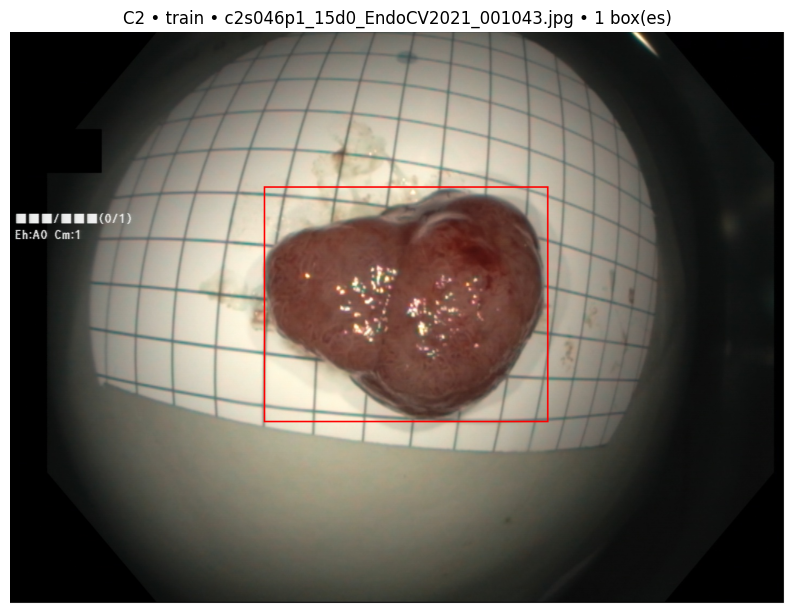

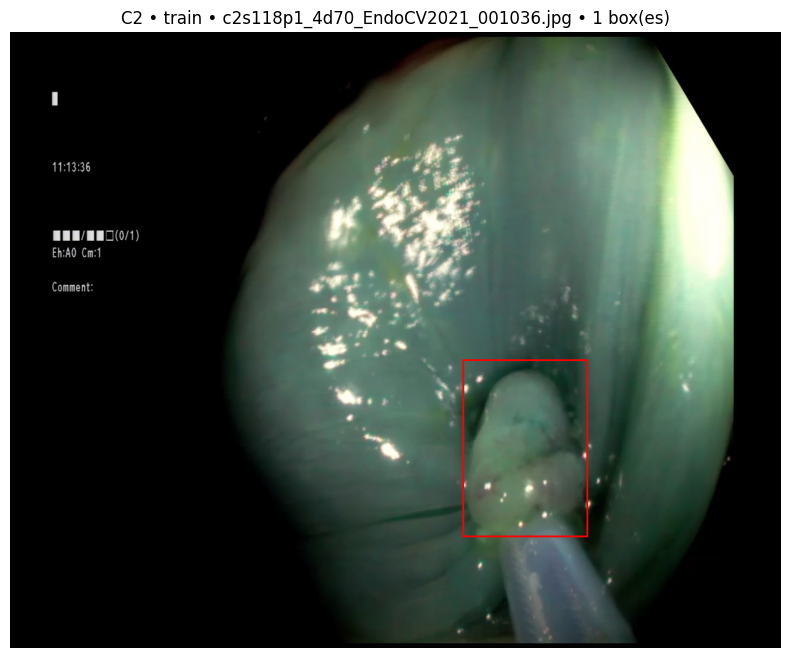

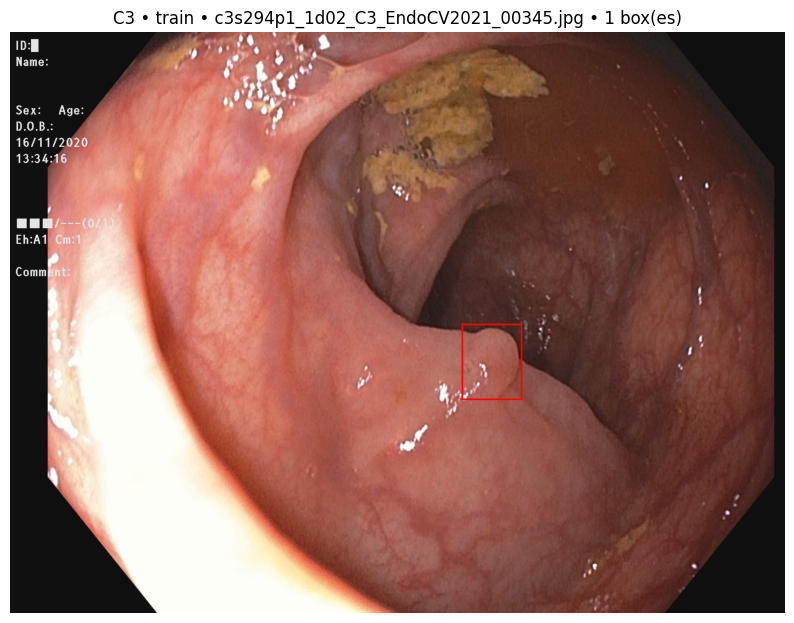

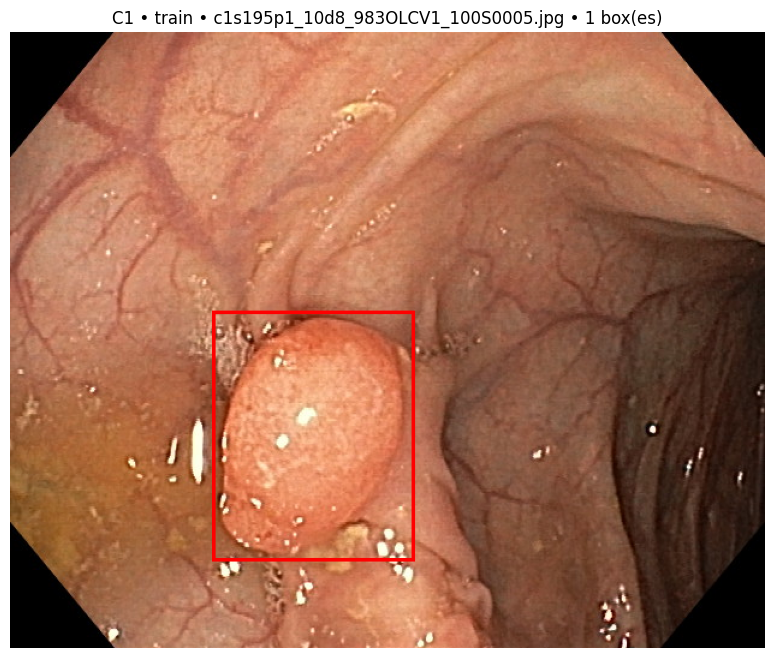

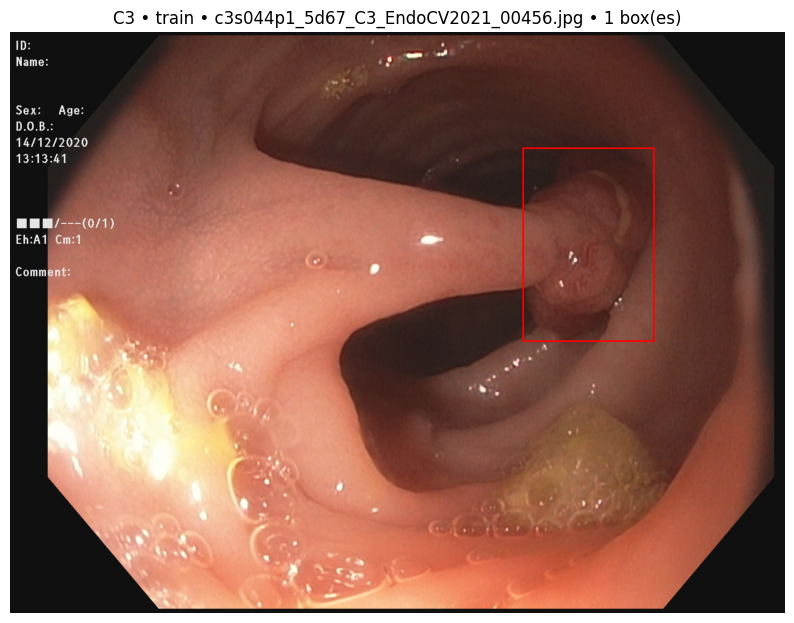

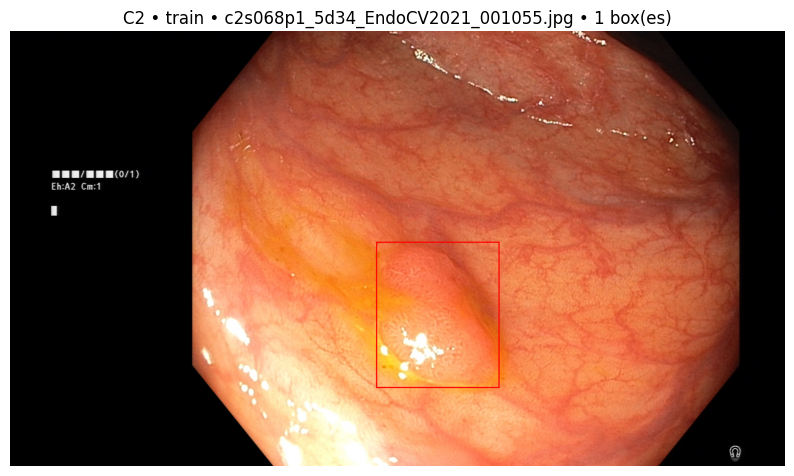

In [5]:
# Examples:
visualize_random()
# visualize_random(centers="C3", splits="val", n=4)
# visualize_random(centers=["C1","C5"], splits=["train"], n=8, seed=42)

In [6]:
import os, json, cv2, numpy as np, torch, random
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [21]:
from pathlib import Path
import torch

ROOT = Path("/content/drive/MyDrive/ErdosFall25/data/center_stratified")

CENTERS = ["C1", "C2", "C3", "C4", "C5"]
SPLITS = ["train", "val"]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2


In [22]:
def get_coco_json(center: str, split: str) -> Path | None:
    """
    Checks these in order:
    - {center}_annotations_{split}.json
    - {center}_annotations.json (no split specified)
    """
    options = [
        ROOT / center / f"{center}_annotations_{split}.json",
        ROOT / center / f"{center}_annotations.json",
    ]
    for p in options:
        if p.exists():
            return p
    return None

In [23]:
train_tfms = A.Compose([
    A.LongestMaxSize(max_size=832),
    A.PadIfNeeded(832, 832, border_mode=cv2.BORDER_CONSTANT),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=10,
                       border_mode=cv2.BORDER_REFLECT_101, p=0.7),
    A.RandomBrightnessContrast(0.08, 0.08, p=0.5),
    A.GaussianBlur(blur_limit=(3,5), p=0.2),
    A.Normalize(mean=(0,0,0), std=(1,1,1)),  # -> float32 in [0,1]
    ToTensorV2()
], bbox_params=A.BboxParams(format="coco", label_fields=["labels"]))

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [24]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

val_tfms = A.Compose([
    A.LongestMaxSize(max_size=832),
    A.PadIfNeeded(832, 832, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize(mean=(0,0,0), std=(1,1,1)),  # -> float32 [0,1]
    ToTensorV2()
], bbox_params=A.BboxParams(format="coco", label_fields=["labels"]))



In [25]:
def clamp_box_coco(x, y, w, h, W, H, eps=1e-6):
    x = max(0.0, float(x)); y = max(0.0, float(y))
    w = max(0.0, float(w)); h = max(0.0, float(h))
    if x + w > W: w = max(0.0, W - x - eps)
    if y + h > H: h = max(0.0, H - y - eps)
    if w < eps or h < eps: return None
    return [x, y, w, h]

def load_coco(coco_path):
    coco = COCO(str(coco_path))
    img_ids = list(coco.imgs.keys())
    return coco, img_ids

def _remap_drive_path_if_needed(path: str) -> str:
    # Rebuild local path from anything containing 'center_stratified'
    if os.path.exists(path):
        return path
    anchor = "center_stratified"
    if anchor in path:
        tail = path.split(anchor, 1)[1].lstrip("/\\")
        cand = ROOT / tail
        if os.path.exists(cand):
            return str(cand)
    return path

def load_image_and_ann(coco, img_id):
    info = coco.loadImgs([img_id])[0]
    path = _remap_drive_path_if_needed(info["file_name"])
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    H, W = img.shape[:2]

    ann_ids = coco.getAnnIds(imgIds=[img_id])
    anns = coco.loadAnns(ann_ids)

    bboxes, labels = [], []
    for a in anns:
        clipped = clamp_box_coco(*a["bbox"], W, H)
        if clipped is None:
            continue
        bboxes.append(clipped)  # COCO xywh (pixels)
        labels.append(1)        # single class

    return img, bboxes, labels


In [26]:
def batch_loader(coco, img_ids, batch_size, tfms, drop_empty=False, shuffle=False, seed=None):

    ids = list(img_ids)
    if shuffle:
        rnd = random.Random(seed)
        rnd.shuffle(ids)

    i = 0
    while i < len(ids):
        batch_ids = ids[i:i+batch_size]
        imgs, targets = [], []

        for img_id in batch_ids:
            # robust file handling
            try:
                img, bboxes, labels = load_image_and_ann(coco, img_id)
            except FileNotFoundError:
                # silently skip missing/corrupt images
                continue

            t = tfms(image=img, bboxes=bboxes, labels=labels)
            img_t = t["image"]
            bxs   = t["bboxes"]
            lbs   = t["labels"]

            if not bxs and drop_empty:
                continue  # skip this sample if requested

            if bxs:
                boxes_xyxy = torch.tensor(
                    [[b[0], b[1], b[0]+b[2], b[1]+b[3]] for b in bxs],
                    dtype=torch.float32
                )
                labels_t = torch.tensor(lbs, dtype=torch.int64)
            else:
                boxes_xyxy = torch.zeros((0, 4), dtype=torch.float32)
                labels_t   = torch.zeros((0,),     dtype=torch.int64)

            targets.append({
                "boxes":    boxes_xyxy,
                "labels":   labels_t,
                "image_id": torch.tensor([img_id], dtype=torch.int64),
            })
            imgs.append(img_t)

        if imgs:  # only yield non-empty batches
            yield imgs, targets

        i += batch_size


In [27]:
model = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
in_feat = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_feat, NUM_CLASSES)
model.to(DEVICE)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [28]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,
                            momentum=0.9, weight_decay=0.0005)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.5)

In [29]:
import numpy as np
from pycocotools.cocoeval import COCOeval

@torch.no_grad()
def evaluate_epoch(model, coco_gt, img_ids, tfms, device, category_id=1):
    """
    Returns: dict with precision (IoU=0.5), recall (IoU=0.5),
             mAP50, mAP50_95
    """
    model.eval()
    results = []

    for img_id in img_ids:
        # load image only; GT comes from coco_gt
        img, _, _ = load_image_and_ann(coco_gt, img_id)  # uses your path remap
        t = tfms(image=img, bboxes=[], labels=[])        # just to tensor/resize/pad
        im_t = t["image"].to(device)

        # inference
        with torch.amp.autocast('cuda', enabled=(device.type=="cuda")):
            pred = model([im_t])[0]

        boxes_xyxy = pred["boxes"].detach().cpu().numpy()
        scores     = pred["scores"].detach().cpu().numpy()
        labels     = pred["labels"].detach().cpu().numpy()

        # build COCO-format results (xywh)
        if len(boxes_xyxy):
            xywh = np.column_stack([
                boxes_xyxy[:,0],
                boxes_xyxy[:,1],
                boxes_xyxy[:,2] - boxes_xyxy[:,0],
                boxes_xyxy[:,3] - boxes_xyxy[:,1],
            ])
            for b, s, _ in zip(xywh, scores, labels):
                results.append({
                    "image_id": int(img_id),
                    "category_id": int(category_id),  # single-class
                    "bbox": [float(x) for x in b],
                    "score": float(s),
                })

    if len(results) == 0:
        return {"precision": 0.0, "recall": 0.0, "map50": 0.0, "map50_95": 0.0}

    coco_dt = coco_gt.loadRes(results)
    ev = COCOeval(coco_gt, coco_dt, iouType="bbox")
    ev.params.imgIds = img_ids  # evaluate only these images
    ev.evaluate(); ev.accumulate(); ev.summarize()

    # COCO summary:
    map50_95 = float(ev.stats[0])  # AP @[.50:.95]
    map50    = float(ev.stats[1])  # AP @.50

    # Derive mean precision/recall at IoU=0.5 from detailed arrays
    # precision shape: T x R x K x A x M
    P = ev.eval["precision"]
    ious = ev.params.iouThrs
    t50 = np.where(np.isclose(ious, 0.5))[0][0]
    # all categories, area=all(0), maxDet=100(2)
    p_slice = P[t50, :, :, 0, 2]
    p_vals = p_slice[p_slice > -1]
    precision = float(p_vals.mean()) if p_vals.size else 0.0

    # recall shape: T x K x A x M
    R = ev.eval["recall"]
    r_slice = R[t50, :, 0, 2]
    r_vals = r_slice[r_slice > -1]
    recall = float(r_vals.mean()) if r_vals.size else 0.0

    return {"precision": precision, "recall": recall, "map50": map50, "map50_95": map50_95}


In [30]:
from torch.nn.utils import clip_grad_norm_

CENTERS = ["C1","C2","C3","C4","C5"]
BATCH   = 4
EPOCHS  = 250
MAX_NORM = 5.0

for CENTER in CENTERS:
    coco_train_path = get_coco_json(CENTER, "train")
    if coco_train_path is None:
        print(f"[skip] {CENTER}: no train annotations")
        continue
    coco_train, train_ids = load_coco(coco_train_path)

    # val fallback: use val if present, else train
    coco_val_path = get_coco_json(CENTER, "val") or coco_train_path
    coco_val, val_ids = load_coco(coco_val_path)

    # model/opt/sched/scaler (fresh per center)
    model = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
    in_feat = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feat, NUM_CLASSES)
    model = model.to(DEVICE)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_sched  = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    scaler    = torch.amp.GradScaler('cuda', enabled=(DEVICE.type=="cuda"))

    best_map = -1.0
    best_path = ROOT / CENTER / f"fasterrcnn_{CENTER.lower()}_best.pth"

    print(f"\n=== Training {CENTER} ===")
    for epoch in range(EPOCHS):
        random.shuffle(train_ids)
        model.train()
        total_loss, steps = 0.0, 0

        for imgs, targets in batch_loader(coco_train, train_ids, BATCH, tfms=train_tfms, shuffle=False):
            if not imgs:
                continue
            # ensure float in [0,1]
            imgs    = [i.to(DEVICE, dtype=torch.float32) / 255.0 if i.dtype==torch.uint8 else i.to(DEVICE) for i in imgs]
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=(DEVICE.type=="cuda")):
                loss_dict = model(imgs, targets)
                loss = sum(loss_dict.values())

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            clip_grad_norm_(model.parameters(), MAX_NORM)
            scaler.step(optimizer)
            scaler.update()

            total_loss += float(loss.item())
            steps += 1

        lr_sched.step()
        avg = total_loss / max(1, steps)

        # evaluate on val each epoch
        metrics = evaluate_epoch(model, coco_val, val_ids, val_tfms, DEVICE)
        print(f"[{CENTER}] epoch {epoch+1}/{EPOCHS} "
              f"loss={avg:.4f}  "
              f"P@0.5={metrics['precision']:.3f}  "
              f"R@0.5={metrics['recall']:.3f}  "
              f"mAP@0.5={metrics['map50']:.3f}  "
              f"mAP@0.5:0.95={metrics['map50_95']:.3f}")

        # save best model (by mAP@0.5:0.95)
        if metrics["map50_95"] > best_map:
            best_map = metrics["map50_95"]
            torch.save(model.state_dict(), best_path)
            print(f"best so far → {best_path}  (mAP@0.5:0.95={best_map:.3f})")

    # also save last epoch (optional)
    last_path = ROOT / CENTER / f"fasterrcnn_{CENTER.lower()}_last.pth"
    torch.save(model.state_dict(), last_path)
    print("Saved last:", last_path)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

=== Training C1 ===


KeyError: 'info'